In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import osmnx as ox
import contextily as cx

import matplotlib.pyplot as plt

ox.config(log_console=True, use_cache=True)
ox.__version__

'0.16.2'

In [2]:
# find a list of American cities and use pandas to read them in
cities = pd.read_html("https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population")
cities = cities[4]

cities = pd.DataFrame({'city': cities['City'].str.replace('\[.*\]', ''),
                       'state': cities['State[c]']})

In [3]:
import json
import googlemaps

# import a Google API key for geocoding
with open("google.json", "r") as token:
    GOOGLE_KEY = json.load(token)["key"]
    
gmaps = googlemaps.Client(key=GOOGLE_KEY)

In [4]:
lats = list()
lons = list()

# geocode each city center with a dummy address
for i in np.arange(0, len(cities.city)):
    metro = cities['city'][i]
    state = cities['state'][i]
    
    # note that such a vague query is why we need to use Google rather than OSM or a free service
    location = f"City Hall, City of {metro}, {state}, USA"
    
    result = gmaps.geocode(location)

    # select latitude and longitude from the results
    lats.append(result[0]['geometry']['location']['lat'])
    lons.append(result[0]['geometry']['location']['lng'])

In [5]:
# append data to our cities data frame
cities['lat'] = lats
cities['lon'] = lons

In [6]:
# manually change Las Vegas, which kept geocoding to North Las Vegas
cities.loc[26, 'lat'] = 36.16738746854798
cities.loc[26, 'lon'] = -115.14852388829269

cities.loc[26]

city     Las Vegas
state       Nevada
lat        36.1674
lon       -115.149
Name: 26, dtype: object

In [7]:
# save the data
cities.to_csv("cities.csv")

In [8]:
# Enter on this step from now on
cities = pd.read_csv('cities.csv', index_col=0)

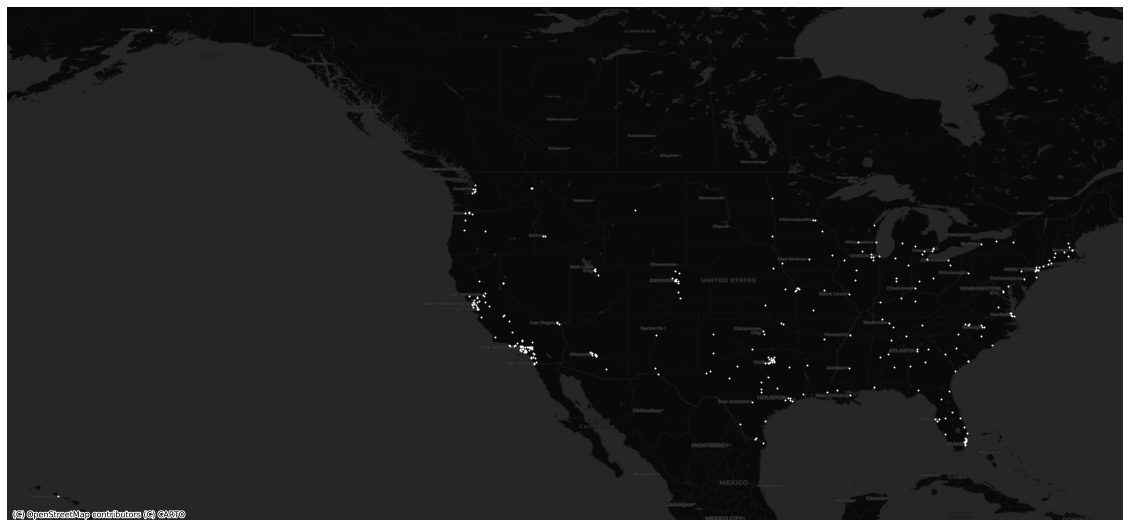

In [11]:
# plot the data to see what we are working with
gdf = gpd.GeoDataFrame(cities, geometry=gpd.points_from_xy(cities.lon, cities.lat))

ax = cities.plot.scatter("lon", "lat", 
                         c='w', s=1, alpha=0.9,
                         figsize=(20, 10))

ax.set_axis_off()
cx.add_basemap(ax, crs={'init': 'epsg:4326'},
               source=cx.providers.CartoDB.DarkMatter)

In [12]:
edges = list()
nodes = list()

graphs = list()

# iterate through graph the street networks around all of these points
for i in np.arange(0, cities.shape[0]):
    
    G = ox.graph_from_point((cities['lat'][i], cities['lon'][i]), 
                            dist=1000, 
                            network_type='all')
    
    N, E = ox.graph_to_gdfs(G)
    
    N['city'] = cities.city[i]
    E['city'] = cities.city[i]
    
    nodes.append(N)
    edges.append(E)
    
    graphs.append(G)
    
edges = gpd.GeoDataFrame(pd.concat(edges, ignore_index=False))
nodes = gpd.GeoDataFrame(pd.concat(nodes, ignore_index=False))

In [13]:
import pickle

pickle.dump(graphs, open("graphs.p", "wb"))

edges_clean = ox.io._stringify_nonnumeric_cols(edges)
nodes_clean = ox.io._stringify_nonnumeric_cols(nodes)

nodes_clean.to_file("nodes_us.gpkg", driver="GPKG")
edges_clean.to_file("edges_us.gpkg", driver="GPKG")

In [14]:
import pickle

graphs = pickle.load(open("graphs.p", "rb"))

nodes = gpd.read_file("nodes_us.gpkg")
edges = gpd.read_file("edges_us.gpkg")

In [15]:
street_widths = {'footway' : 0.5,
                 'steps' : 0.5,
                 'pedestrian' : 0.5,
                 'path' : 0.5,
                 'track' : 0.5,
                 'service' : 2,
                 'residential' : 3,
                 'primary' : 5,
                 'motorway' : 6}

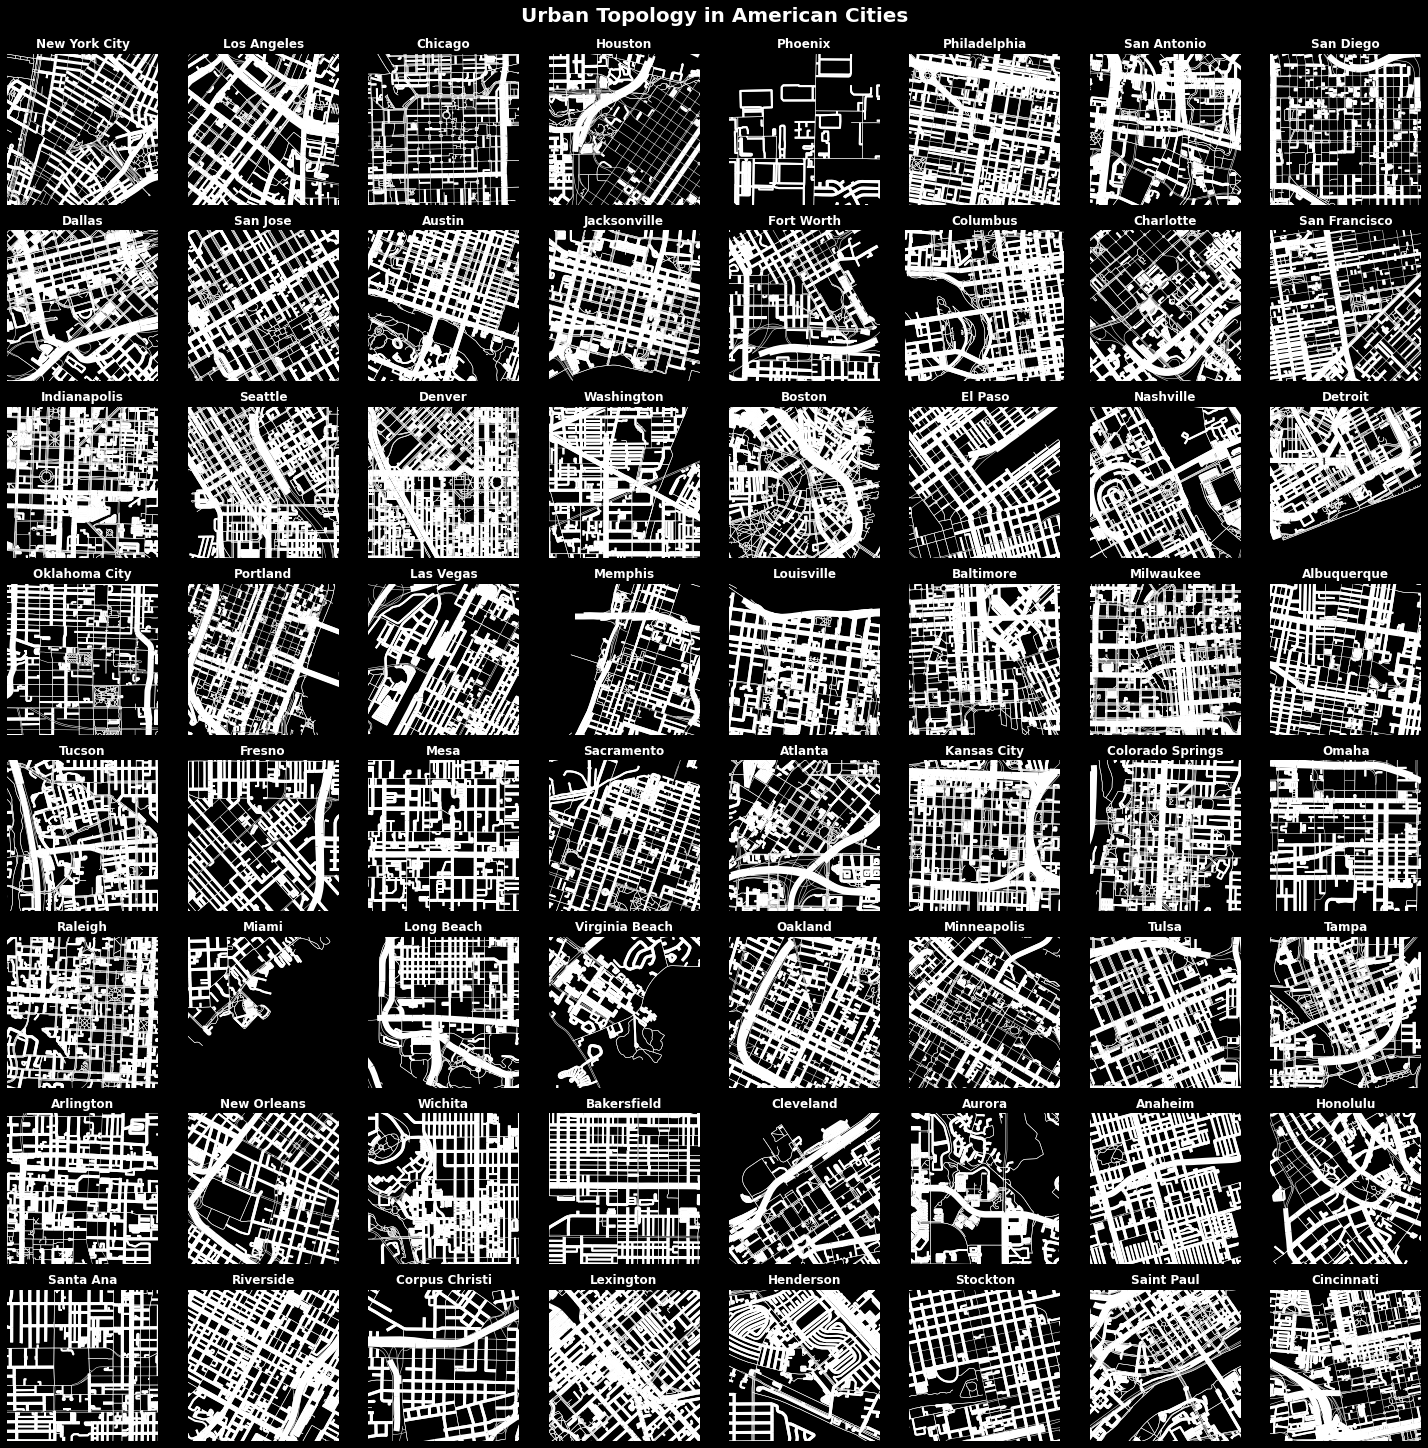

In [16]:
fig, axs = plt.subplots(8, 8, figsize=(20, 20), 
                        facecolor='k',
                        constrained_layout=True, 
                        subplot_kw=dict(aspect='equal'))

axs = axs.ravel()

for i in np.arange(0, 64):
    
    node = nodes[nodes['city']==cities.city[i]]
    edge = edges[edges['city']==cities.city[i]]
    
    # this code is exactly what happens inside the osmnx.plot.plot_figure_ground() function
    edge_linewidths = []
    
    default_width = 0.5
    
    for label in edge.highway:
        street_type = label[0] if isinstance(label, list) else label
    
        if street_type in street_widths:
            edge_linewidths.append(street_widths[street_type])
        else:
            edge_linewidths.append(default_width)
    
    #  we are just editing the function here to plot on axis i so that we can have small multiples 
    edge.plot(ax=axs[i], color='w', lw=edge_linewidths)
    
    bbox = ox.utils_geo.bbox_from_point((cities['lat'][i], cities['lon'][i]), 800, project_utm=False)
    
    north, south, east, west = bbox
    axs[i].set_ylim((south, north))
    axs[i].set_xlim((west, east))
    axs[i].set_title(cities['city'][i], color='w', weight='bold')

    axs[i].margins(0)
    axs[i].axis('off')
    
fig.suptitle('Urban Topology in American Cities', color='w', size=20, weight='bold')
fig.savefig('urban-topology.png', facecolor=fig.get_facecolor(), dpi=120, bbox_inches='tight')

In [17]:
def reverse_bearing(x):
    return x + 180 if x < 180 else x - 180

In [18]:
weight_by_length = False

bearings = {}

for i in np.arange(0, 64):
    
    G = graphs[i]
    U = ox.add_edge_bearings(ox.get_undirected(G))
    
    if weight_by_length:
        
        city_bearings = []
        
        for u, v, k, d in U.edges(keys=True, data=True):
            city_bearings.extend([d['bearing']] * int(d['length']))
            
        b = pd.Series(city_bearings)
        bearings[name] = pd.concat([b, b.map(reverse_bearing)]).reset_index(drop='True')
        
    else:
        
        b = pd.Series([d['bearing'] for u, v, k, d in U.edges(keys=True, data=True)])
        bearings[i] = pd.concat([b, b.map(reverse_bearing)]).reset_index(drop='True')

In [19]:
def count_and_merge(n, bearings):
    
    n = n * 2
    bins = np.arange(n + 1) * 360 / n
    count, _ = np.histogram(bearings, bins=bins)
    
    count = np.roll(count, 1)
    return count[::2] + count[1::2]

In [20]:
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors

mpl.rcParams.update({'text.color':"white",
                     'axes.labelcolor':"white"})

def polar_plot(ax, bearings, n=36, title=''):

    bins = np.arange(n + 1) * 360 / n
    count = count_and_merge(n, bearings)
    _ , division = np.histogram(bearings, bins=bins)
    frequency = count / count.sum()
    division = division[0:-1]
    width =  2 * np.pi / n

    ax.set_theta_zero_location('N')
    ax.set_theta_direction('clockwise')

    x = division * np.pi / 180
    bars = ax.bar(x, height=frequency, width=width, align='center', bottom=0, zorder=2, 
                  color='w', edgecolor='w', linewidth=0.1, alpha=1)
    
    ax.set_ylim(top=frequency.max())
    
    title_font = {'weight':'bold'}
    xtick_font = {'weight':'bold', 'alpha':1.0, 'zorder':3}
    ytick_font = {'weight':'bold', 'alpha':0.2, 'zorder':3}
    
    ax.set_title(title.upper(), y=1.05, fontdict=title_font)
    
    ax.set_facecolor('k')
    
    ax.set_yticks(np.linspace(0, max(ax.get_ylim()), 5))
    yticklabels = ['{:.2f}'.format(y) for y in ax.get_yticks()]
    yticklabels[0] = ''
    ax.set_yticklabels(labels=yticklabels, fontdict=ytick_font)
    
    xticklabels = ['N', '', 'E', '', 'S', '', 'W', '']
    ax.set_xticklabels(labels=xticklabels, fontdict=xtick_font)
    ax.tick_params(axis='x', which='major', pad=-2)

In [21]:
cities['key'] = pd.Series(np.array(list(bearings.keys())), dtype = 'int')
cities.head()

Unnamed: 0           city       state        lat         lon  \
0           0  New York City    New York  40.713524  -74.006710   
1           1    Los Angeles  California  34.053714 -118.242653   
2           2        Chicago    Illinois  41.883823  -87.632078   
3           3        Houston       Texas  29.760159  -95.369418   
4           4        Phoenix     Arizona  33.439971 -112.204870   

                      geometry  key  
0   POINT (-74.00671 40.71352)  0.0  
1  POINT (-118.24265 34.05371)  1.0  
2   POINT (-87.63208 41.88382)  2.0  
3   POINT (-95.36942 29.76016)  3.0  
4  POINT (-112.20487 33.43997)  4.0

In [22]:
keys = np.array(list(bearings.keys()))

plots = keys[0:64]
reset = cities.set_index('key')

trim = reset.loc[keys, :]

<ipython-input-20-3cf8c59f4fa1>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=xticklabels, fontdict=xtick_font)


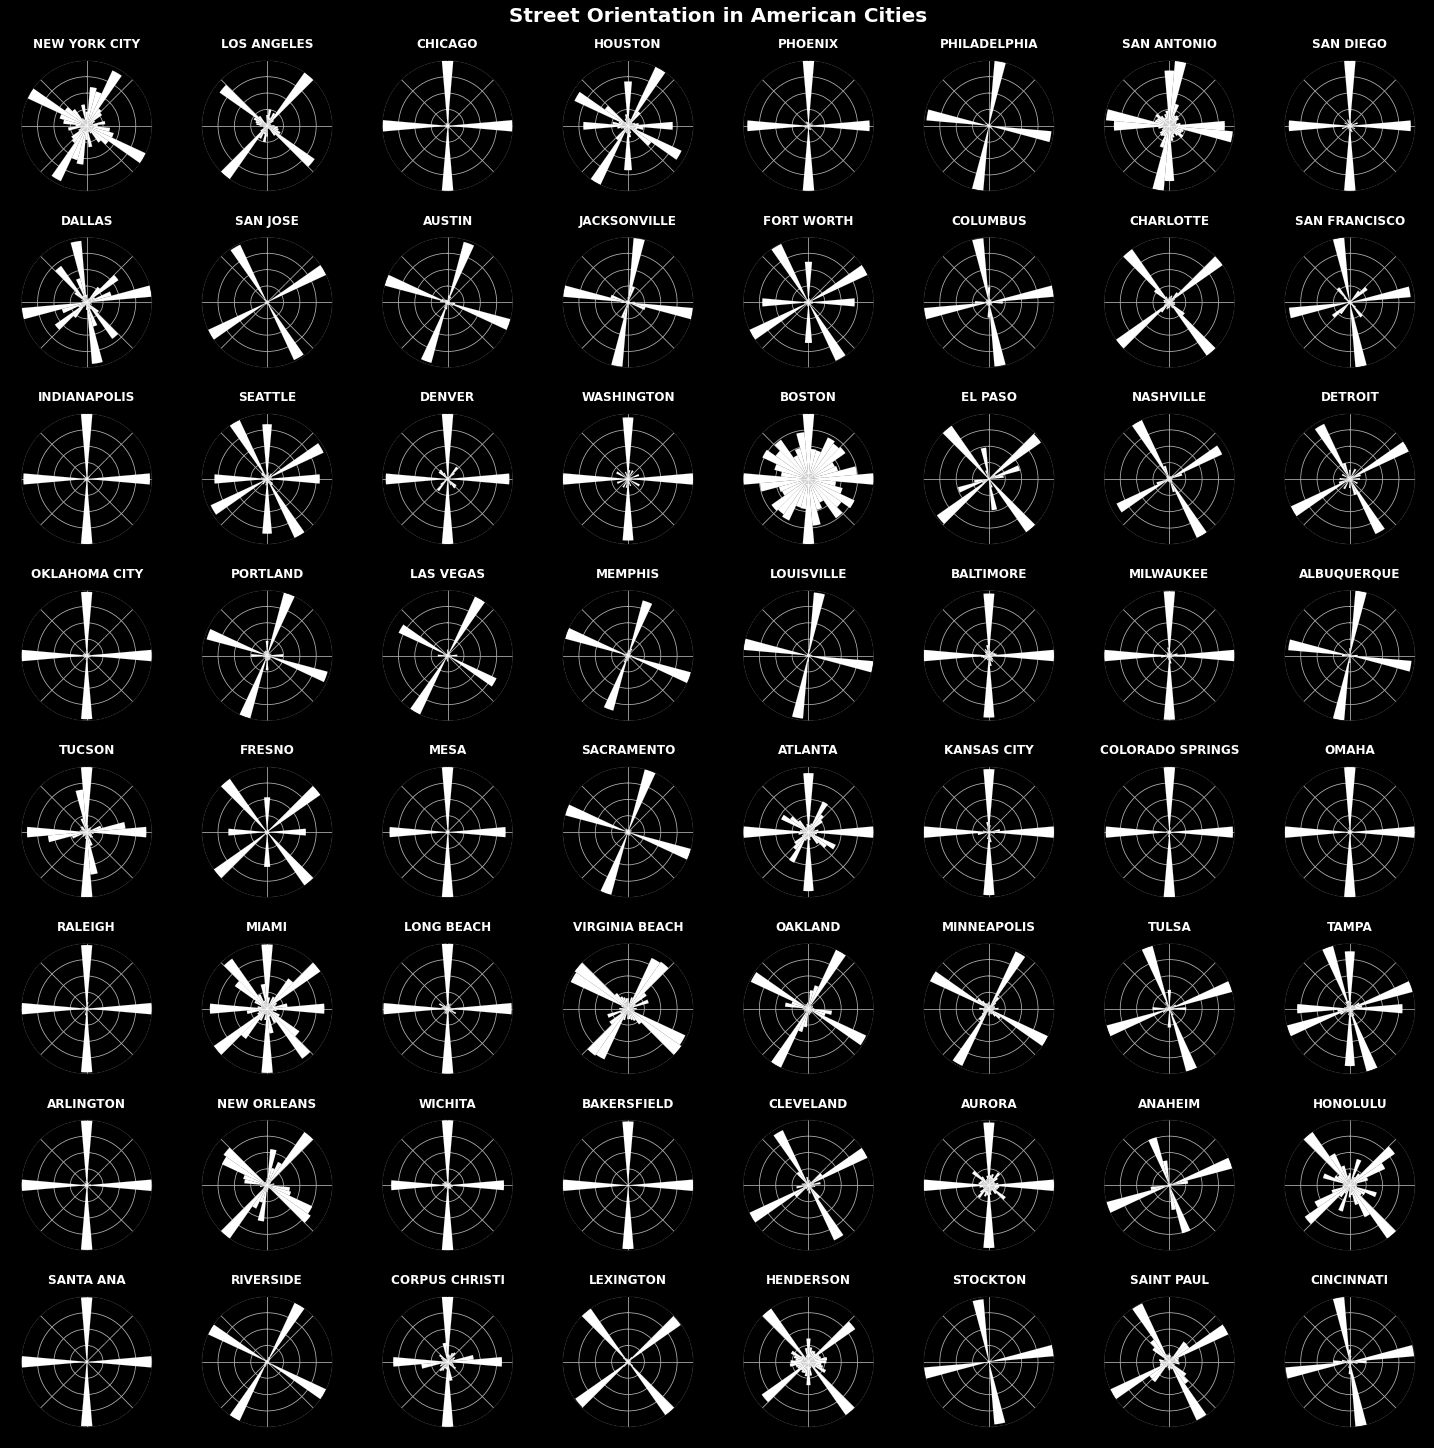

In [23]:
n = 64
ncols = int(np.ceil(np.sqrt(n)))
nrows = int(np.ceil(n / ncols))

fig, axs = plt.subplots(nrows, ncols, 
                        facecolor='k',
                        figsize=(20,20), 
                        constrained_layout=True, 
                        subplot_kw={'projection':'polar',
                                    'aspect': 'equal'})

for ax, city in zip(axs.flat, plots):
    polar_plot(ax, bearings[city], title=trim.city[city])

fig.suptitle('Street Orientation in American Cities', color='w', size=20, weight='bold')
fig.savefig('urban-orientation.png', facecolor=fig.get_facecolor(), dpi=120, bbox_inches='tight')

In [24]:
buildings = list()

for i in np.arange(0, len(cities.city)):
    
    name = cities.city[i]
    bldg = ox.geometries_from_point((cities['lat'][i], cities['lon'][i]), dist=1000, tags={'building': True})
    bldg['city'] = name
    
    buildings.append(bldg)

buildings = gpd.GeoDataFrame(pd.concat(buildings, ignore_index=False))

In [59]:
buildings = buildings[['osmid', 
                       'city', 
                       'addr:state', 
                       'ele', 
                       'geometry']].rename(columns={'addr:state': "state",
                                                    'ele': "elevation"})

/Users/andrewrenninger/anaconda3/envs/sandbox/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [60]:
buildings.to_file("buildings.gpkg", driver="GPKG")
buildings = gpd.read_file("buildings.gpkg")

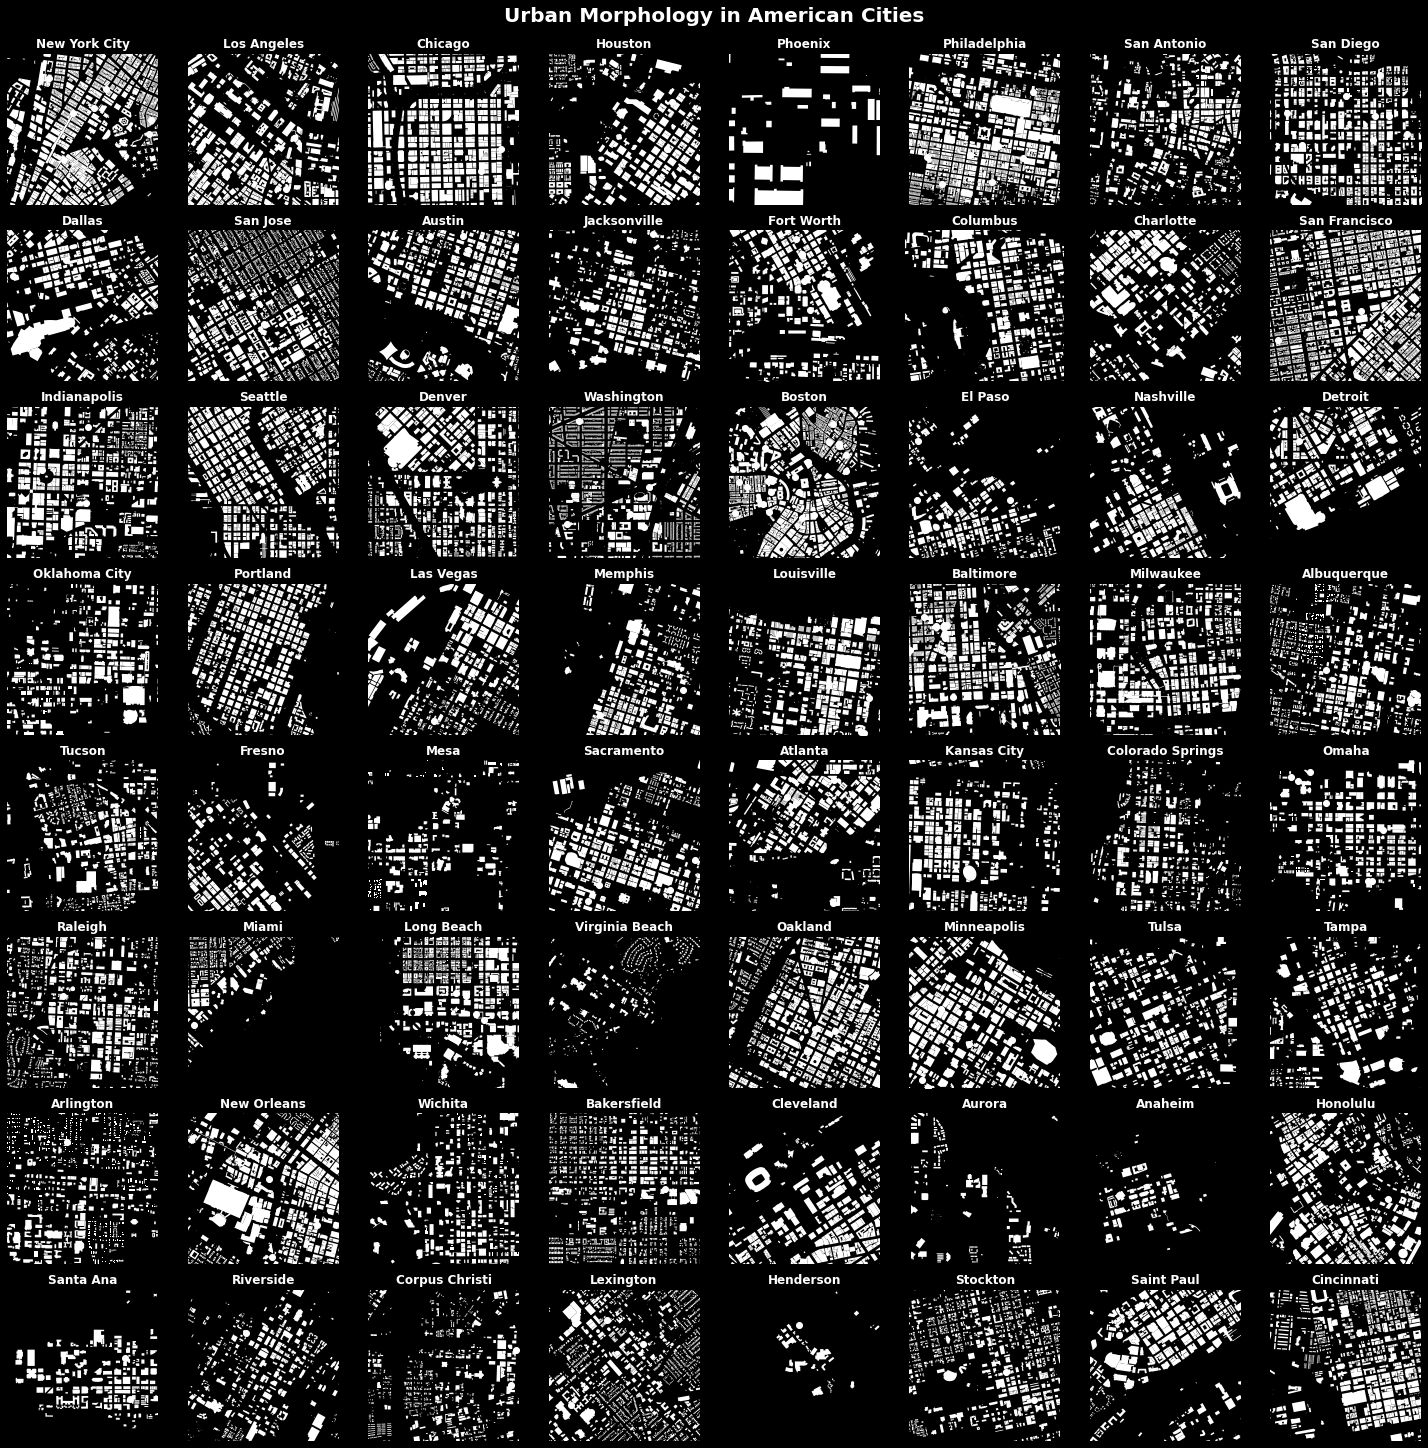

In [26]:
fig, axs = plt.subplots(8, 8, figsize=(20, 20), 
                        facecolor='k',
                        constrained_layout=True, 
                        subplot_kw=dict(aspect='equal'))

axs = axs.ravel()

for i in np.arange(0, 64):
    
    building = buildings[buildings['city']==cities.city[i]]
    
    building.plot(ax=axs[i], color='w')
    
    bbox = ox.utils_geo.bbox_from_point((cities['lat'][i], cities['lon'][i]), 800, project_utm=False)
    
    north, south, east, west = bbox
    axs[i].set_ylim((south, north))
    axs[i].set_xlim((west, east))
    axs[i].set_title(cities['city'][i], color='w', weight='bold')

    axs[i].margins(0)
    axs[i].axis('off')
    
fig.suptitle('Urban Morphology in American Cities', color='w', size=20, weight='bold')
fig.savefig('urban-morphology.png', facecolor=fig.get_facecolor(), dpi=120, bbox_inches='tight')    

In [27]:
world = pd.read_html("https://en.wikipedia.org/wiki/List_of_countries_by_largest_and_second_largest_cities")
world = world[0]

/Users/andrewrenninger/anaconda3/envs/sandbox/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
world.columns = ['country', 'first', 'second', 'source']
world = world.drop('source', axis=1)

world.head()

/Users/andrewrenninger/anaconda3/envs/sandbox/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


country                first          second
0                    Abkhazia              Sukhumi      Tkvarcheli
1                 Afghanistan                Kabul        Kandahar
2  Akrotiri and Dhekelia (UK)  Episkopi Cantonment  Ayios Nikolaos
3     Åland Islands (Finland)            Mariehamn          Jomala
4                     Albania               Tirana          Durrës

In [96]:
results = {}

for i in np.arange(0, len(cities.city)):
    
    bbox = ox.utils_geo.bbox_from_point((cities['lat'][i], cities['lon'][i]), 1000, project_utm=False)
    poly = ox.utils_geo.bbox_to_poly(bbox[0], bbox[1], bbox[2], bbox[3])
    
    city = cities.city[i]
    
    results[city] = {'geometry': poly}

/Users/andrewrenninger/anaconda3/envs/sandbox/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [101]:
results = pd.DataFrame(results).T.reset_index()
results = results.rename(columns={'index': "city"})

/Users/andrewrenninger/anaconda3/envs/sandbox/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [108]:
results = gpd.GeoDataFrame(results)

results.to_file("boxes.shp")

/Users/andrewrenninger/anaconda3/envs/sandbox/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [219]:
frac = pd.read_csv("measures_frac.csv", index_col=0)
area = pd.read_csv("measures_area.csv", index_col=0)

In [222]:
cities = pd.read_csv('cities.csv', index_col=0)

/Users/andrewrenninger/anaconda3/envs/sandbox/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [281]:
focus = cities[(cities['city']=='Denver') | (cities['city']=='Cambridge')].reset_index()

/Users/andrewrenninger/anaconda3/envs/sandbox/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


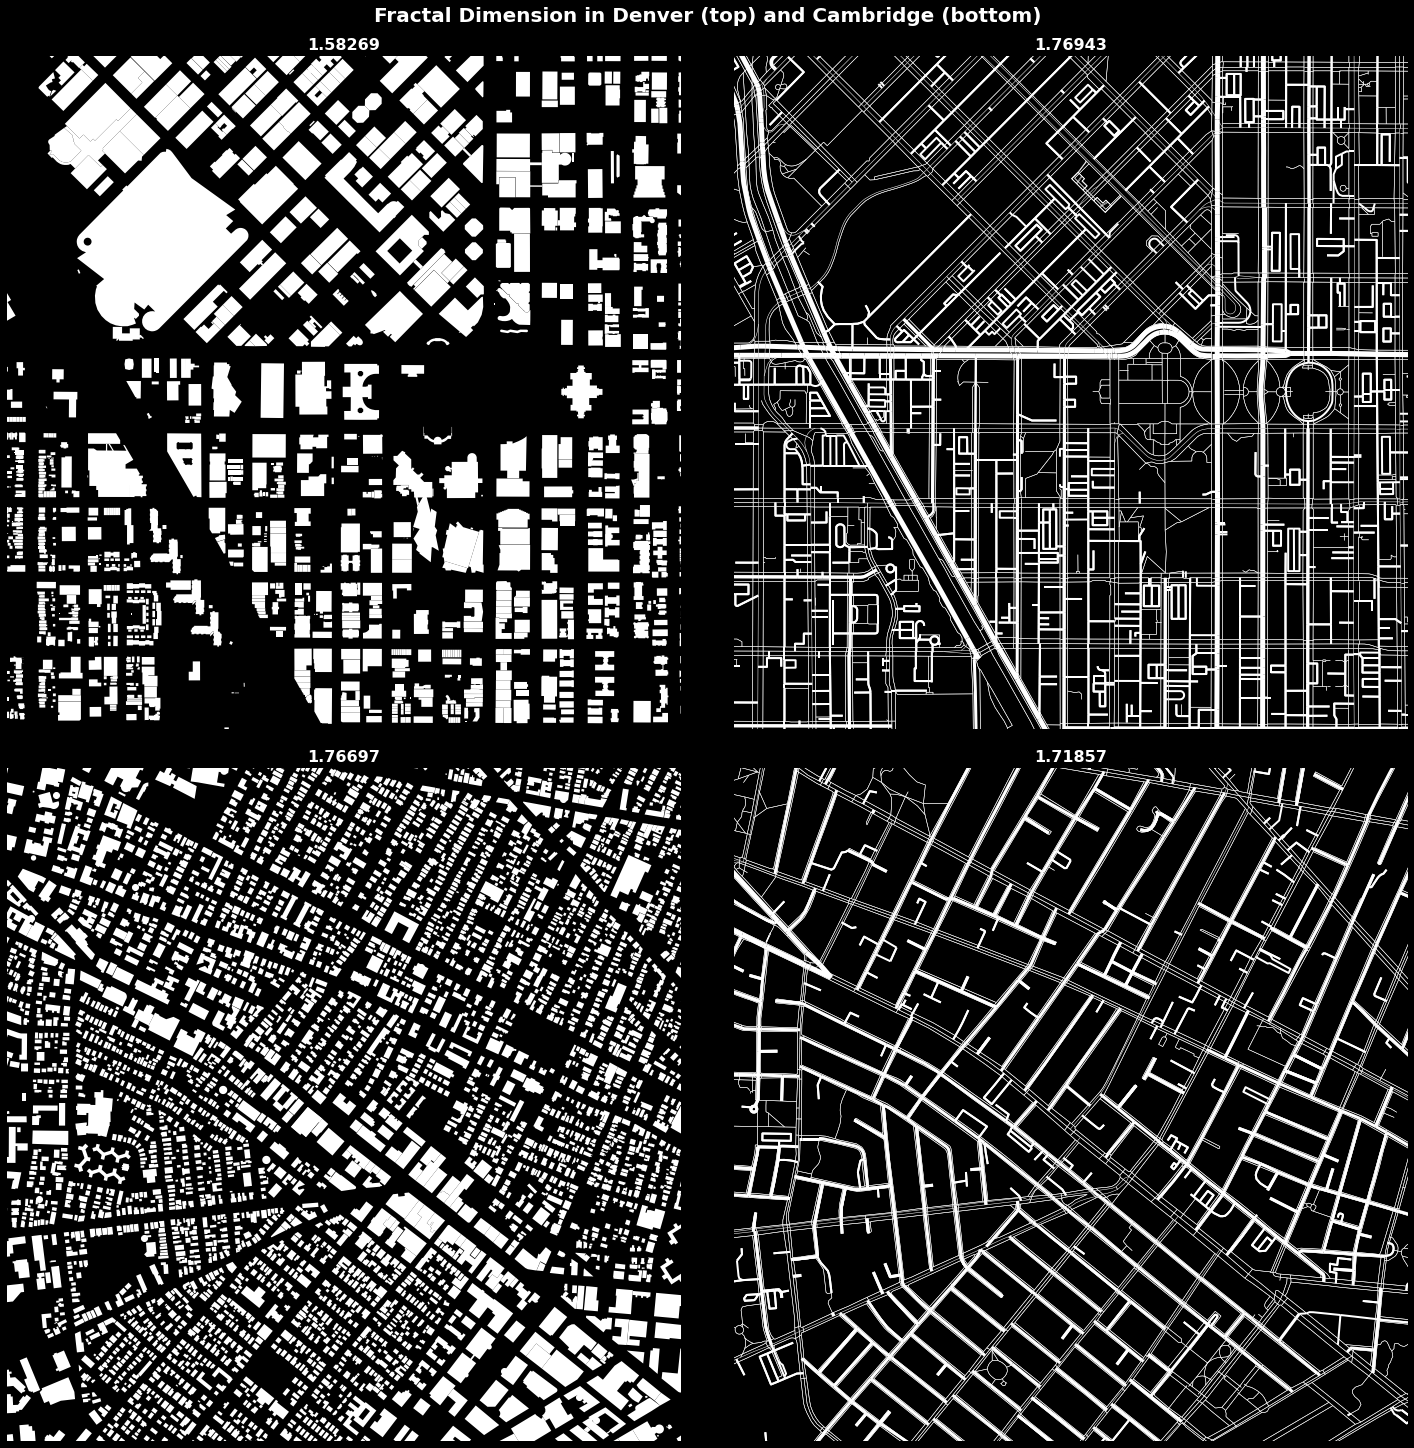

In [328]:
fig, axs = plt.subplots(2, 2, figsize=(20, 20), 
                        facecolor='k',
                        constrained_layout=True, 
                        subplot_kw=dict(aspect='equal'))

for i in np.arange(0, 2):
    
    building = buildings[buildings['city']==focus.city[i]]
    
    building.plot(ax=axs[i, 0], color='w')
    
    s_dim = frac[frac['city']==focus.city[i]]['fractal_buildings'].values[0]
    
    bbox = ox.utils_geo.bbox_from_point((focus['lat'][i], focus['lon'][i]), 800, project_utm=False)
    
    north, south, east, west = bbox
    axs[i, 0].set_ylim((south, north))
    axs[i, 0].set_xlim((west, east))
    axs[i, 0].set_title(round(s_dim, 5), 
                        color='w', weight='bold', size=16)

    axs[i, 0].margins(0)
    axs[i, 0].axis('off')
    
    node = nodes[nodes['city']==focus.city[i]]
    edge = edges[edges['city']==focus.city[i]]
    
    edge_linewidths = []
    
    default_width = 0.5
    
    for label in edge.highway:
        street_type = label[0] if isinstance(label, list) else label
    
        if street_type in street_widths:
            edge_linewidths.append(street_widths[street_type])
        else:
            edge_linewidths.append(default_width)
    
    edge.plot(ax=axs[i, 1], color='w', lw=edge_linewidths)
    
    b_dim = frac[frac['city']==focus.city[i]]['fractal_streets'].values[0]
    
    north, south, east, west = bbox
    axs[i, 1].set_ylim((south, north))
    axs[i, 1].set_xlim((west, east))
    axs[i, 1].set_title(round(b_dim, 5), 
                        color='w', weight='bold', size=16)

    axs[i, 1].margins(0)
    axs[i, 1].axis('off')
    
fig.suptitle('Fractal Dimension in Denver (top) and Cambridge (bottom)', color='w', size=20, weight='bold')
fig.savefig('fractal-dimension.png', facecolor=fig.get_facecolor(), dpi=120, bbox_inches='tight')  